# Oil Companies' Stock Data Analysis

### Question 1:  How much does US gasoline prices affect the stock market in the US oil industry?

### Question 2: How much does COVID-19 affect the stock market in the US oil industry?

In [1]:
# Dependencies and Setup
import os
import csv
import requests
import json
import hvplot.pandas
import matplotlib.image as mpimg

import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

# yahoo finance library
import yfinance as yf

# Import the API key from geoapify
from config import geoapify_key

## Why are we focusing on 6 oil companies? (How to choose them.)
- Make data frame of 30 major oil companies adding some informations from yahoo finace and geoapify.
- Filter them only to companies in the United States and the United Kingdom.
  (The United Kindom is included because some companies that have a strong impact on the U.S. oil industry are headquartered there.)
- Sort them by gross profits.
- Choose top 6 oil comapnies

### 30 major oil companies (from yahoo finance)

In [2]:
# Read 'oil_company_list.csv' and store it into Pandas DataFrames
csv_file_path_2 = 'Resources/30_oil_companies.csv'

oil_company_list_data = pd.read_csv(csv_file_path_2)

# Collect some data of the oil compnanies using yfinance 
ticker_symbols = oil_company_list_data["Symbol"]

companies_info = []

for ticker in ticker_symbols:
    try:
        ticker_object = yf.Ticker(ticker)
        info = ticker_object.info
        
        # Company address for mapping.
        address1 = info.get("address1")
        city = info.get("city")
        state = info.get("state")
        zip_code = info.get("zip")
        country = info.get("country")
        address = f"{address1}, {city}, {state}, {zip_code}, {country}"
        #companies_address[ticker_symbol] = address
        
        # How large is the company?
        company_name = info.get("longName")
        num_employees = info.get("fullTimeEmployees")
        market_cap = info.get("marketCap")
        enterprise_value = info.get("enterpriseValue")
        total_revenue = info.get("totalRevenue")
        gross_profits = info.get("grossProfits")
        total_debt = info.get("totalDebt")
       
        companies_info.append({
            "Company Name": company_name, 
            "Ticker": ticker, 
            "Address": address,
            "Full Time Employees": num_employees,
            "Market Capitalization (Market Cap)": market_cap,
            "Enterprise Value (EV)": enterprise_value,
            "Total Revenue": total_revenue,
            "Gross Profits": gross_profits,
            "Total Debt": total_debt
        })

    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")

# Convert companies_info to a DataFrame
companies_info_df = pd.DataFrame(companies_info)

# clean data
companies_info_df_cleaned = companies_info_df.dropna()

#save to csv file
output_file = os.path.join("Results/30_companies_info_total.csv")
companies_info_df_cleaned.to_csv(output_file, index=False)

companies_info_df_cleaned.head()

,Company Name,Ticker,Address,Full Time Employees,Market Capitalization (Market Cap),Enterprise Value (EV),Total Revenue,Gross Profits,Total Debt
0,Exxon Mobil Corporation,XOM,"5959 Las Colinas Boulevard, Irving, TX, 75039-...",62000.0,429930479616,460750585856,3.679770e+11,133715000000,4.149600e+10
1,Chevron Corporation,CVX,"6001 Bollinger Canyon Road, San Ramon, CA, 945...",43846.0,296550858752,313186058240,2.146720e+11,98886000000,2.151400e+10
2,Shell plc,SHEL,"Shell Centre, London, None, SE1 7NA, United Ki...",91140.0,203546804224,246093201408,3.585890e+11,97308000000,8.436600e+10
3,TotalEnergies SE,TTE,"2, place Jean Millier, Courbevoie, None, 92078...",101279.0,147831996416,180737343488,2.386820e+11,92261000000,5.641200e+10
4,ConocoPhillips,COP,"925 North Eldridge Parkway, Houston, TX, 77079...",9700.0,138721280000,147951140864,6.877500e+10,39598000000,1.644400e+10


### Locations of the companies

In [3]:
# Find latitude and longitude of company from geoapify.com
for index, company in companies_info_df_cleaned.iterrows():
    company_address = company["Address"]
    #company_address = '5959 Las Colinas Boulevard, Irving, TX, 75039-2298, United States'
    url = f"https://api.geoapify.com/v1/geocode/search?text={company_address}&apiKey={geoapify_key}"
    try:
        # Send the API request
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for HTTP errors (e.g., 404)

        data = response.json()
        latitude = data["features"][0]["properties"]["lat"]
        longitude =data["features"][0]["properties"]["lon"]
        #print(f"Latitude: {latitude}, Longitude: {longitude}")
        companies_info_df_cleaned.loc[index, ["Latitude", "Longitude"]] = [latitude, longitude]
    except:
        print("Company not found")

In [4]:
%%capture --no-display
map_plot_1 = companies_info_df_cleaned.hvplot.points(
"Longitude",
"Latitude",
geo=True,
tiles="OSM",
frame_width = 800,
frame_height = 600,
size = "Gross Profits",
scale = 0.0001,
color = "Company Name"
)
# Display the map plot
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Company Name,Gross Profits)

### 6 major companies based on gross profit in the United States and the United Kindom

In [5]:
# Filter company data only to companies in the United States and the United Kingdom.
# The United Kindom is included because some companies that have a strong impact on the U.S. oil industry are headquartered there.
filtered_df = companies_info_df_cleaned[
    companies_info_df_cleaned['Address'].str.contains("United States|United Kingdom")
]
# Sort the DataFrame by "Gross Profits" in descending order
sorted_df = filtered_df.sort_values(by="Gross Profits", ascending=False)

# Select the top 6 companies
top_companies_profit = sorted_df.head(6)

#save to csv file
output_file = os.path.join("Results/6_companies_info_total.csv")
top_companies_profit.to_csv(output_file, index=False)

top_companies_profit

,Company Name,Ticker,Address,Full Time Employees,Market Capitalization (Market Cap),Enterprise Value (EV),Total Revenue,Gross Profits,Total Debt,Latitude,Longitude
0,Exxon Mobil Corporation,XOM,"5959 Las Colinas Boulevard, Irving, TX, 75039-...",62000.0,429930479616,460750585856,3.679770e+11,133715000000,4.149600e+10,32.890255,-96.949441
1,Chevron Corporation,CVX,"6001 Bollinger Canyon Road, San Ramon, CA, 945...",43846.0,296550858752,313186058240,2.146720e+11,98886000000,2.151400e+10,37.758335,-121.959458
2,Shell plc,SHEL,"Shell Centre, London, None, SE1 7NA, United Ki...",91140.0,203546804224,246093201408,3.585890e+11,97308000000,8.436600e+10,51.463735,-0.021389
5,BP p.l.c.,BP,"1 St James's Square, London, None, SW1Y 4PD, U...",67600.0,103636328448,467766444032,2.275870e+11,70171000000,6.069900e+10,51.507730,-0.134570
4,ConocoPhillips,COP,"925 North Eldridge Parkway, Houston, TX, 77079...",9700.0,138721280000,147951140864,6.877500e+10,39598000000,1.644400e+10,29.783352,-95.617801
13,Marathon Petroleum Corporation,MPC,"539 South Main Street, Findlay, OH, 45840-3229...",17800.0,60801998848,80502947840,1.575150e+11,26565000000,2.856500e+10,41.036497,-83.650163


In [6]:
%%capture --no-display
map_plot_2 = top_companies_profit.hvplot.points(
"Longitude",
"Latitude",
geo=True,
tiles="OSM",
frame_width = 800,
frame_height = 600,
size = "Gross Profits",
scale = 0.0002,
color = "Company Name"
)
# Display the map plot
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Company Name,Gross Profits)

## How much does US gasolin prices affect the stock market in the US oil industry?
- stock price from yahoo finance
- gasoline price in the US from FRED (https://fred.stlouisfed.org/)
- line regression and r-value between Gasoline price and oil company's stock price

### Stock prices over time of the 6 companies

In [7]:
#stock prices using yfinance for each ticker
companyList = top_companies_profit["Ticker"]
ticker_string = " ".join(companyList)
stock_data = {}

for companyName in companyList:
    # Download data for specific tickers
    companyDataFrame = yf.download(companyName, start="2017-08-01", end="2023-08-01")
    
    # reduce data for specific tickers within a date range
    data_range = yf.download(ticker_string, start="2020-01-01", end="2020-06-01")
    
    # Store the monthly closing prices for the company in the dictionary
    stock_data[companyName] = companyDataFrame['Close'].resample('M').last()

# Convert the dictionary to a DataFrame
stock_data_df = pd.DataFrame(stock_data)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed


### Gasoline price from FRED

In [8]:
# oil price in the US from FRED (https://fred.stlouisfed.org/)
csv_file_path_3 = 'Resources/OPEC-ORB.csv'

Gasoline_price_data = pd.read_csv(csv_file_path_3)

# clean Gasoline data by month
Gasoline_price_data['Date'] = pd.to_datetime(Gasoline_price_data['Date'])

# Filter the data to include only the desired date range
start_date = "2017-08-01"
end_date = "2023-08-01"
Gasoline_filtered_data = Gasoline_price_data[(Gasoline_price_data['Date'] >= start_date) & (Gasoline_price_data['Date'] <= end_date)]

# Set 'Date' as the index
Gasoline_filtered_data.set_index('Date', inplace=True)

# Resample to get the last date of each month
Gasoline_resampled_data = Gasoline_filtered_data.resample('M').last()

#Delete the last row for matching to the size of data frome of stock prices
last_row_index = Gasoline_resampled_data.index[-1] 
Gasoline_resampled_data.drop(last_row_index, inplace=True)

### Plot of Gasoline price and oil company's stock price

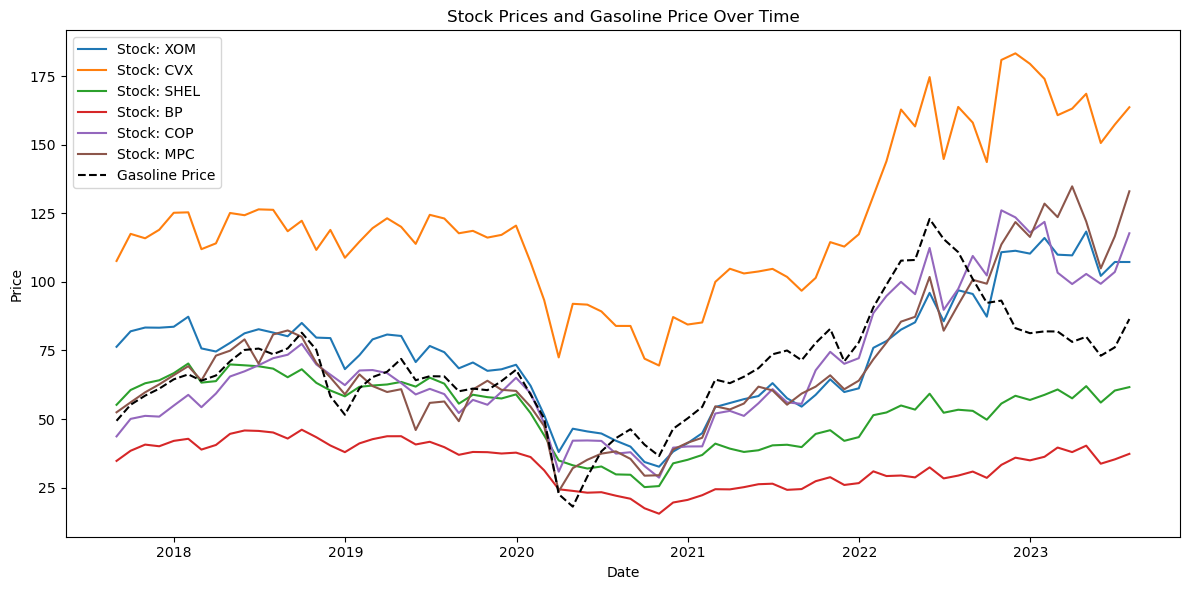

In [9]:
# plotting stock prices and gasoline price and save to figure file
#saved_fig_path = "Results/stock_price_oil_price.png"

plt.figure(figsize=(12, 6))

# Plot stock data for each company
for y_column in stock_data_df.columns:
    y_values = stock_data_df[y_column]
    plt.plot(y_values.index, y_values, label=f"Stock: {y_column}")

# Plot resampled data
plt.plot(Gasoline_resampled_data.index, Gasoline_resampled_data['Value'], label="Gasoline Price", color='black', linestyle='dashed')

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Prices and Gasoline Price Over Time")
plt.legend()
# Save the figure
#plt.savefig(saved_fig_path)

# Display the plot
plt.tight_layout()
plt.show()

### Line regression between Gasoline price and oil company's stock price

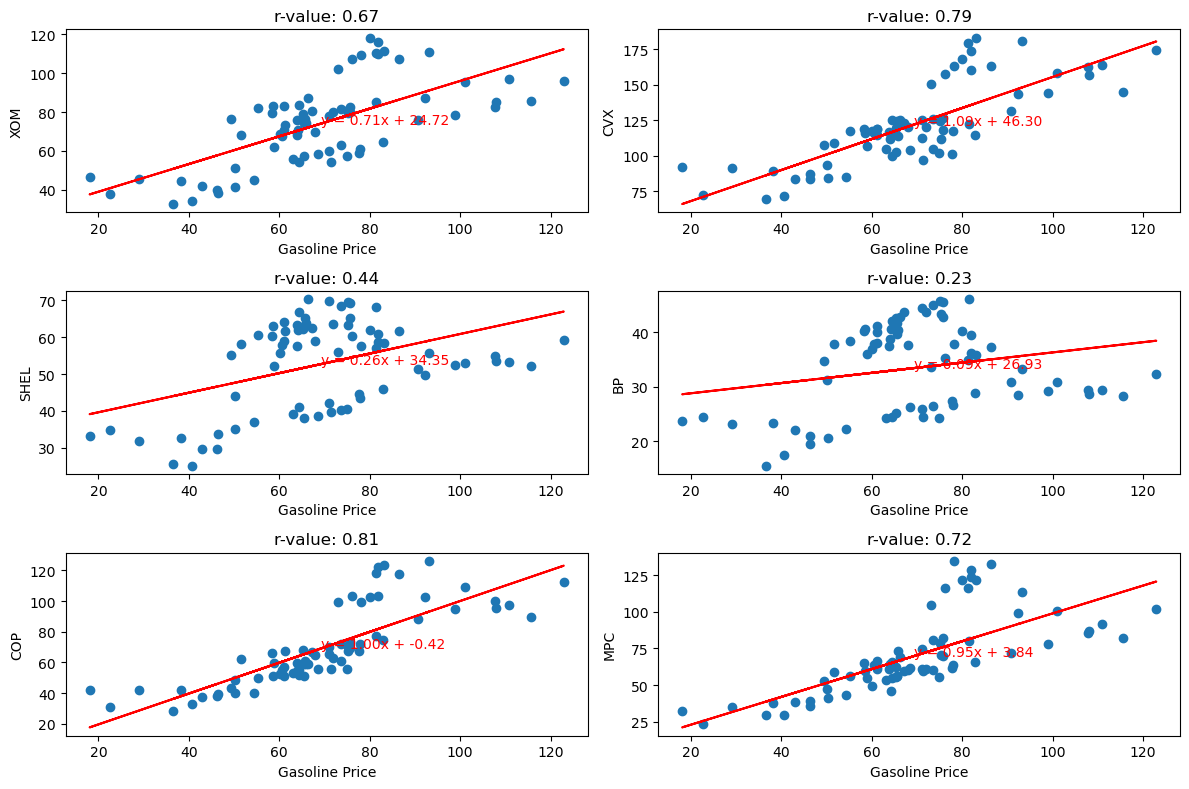

In [10]:
# Define the columns you want to use from the data DataFrame and Gasoline_price_data
x_column = "Gasoline Price"  
y_columns = companyList 

# Calculate the number of rows and columns for the subplot grid
num_rows = 3  
num_cols = 2  

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Create plots for each company's stock data
for i, y_column in enumerate(y_columns):
    # Extract x and y values
    x_values = Gasoline_resampled_data["Value"]
    y_values = stock_data_df[y_column]
    
    # Perform linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    
    # Select the appropriate subplot for the current company
    ax = axes[i]
    
    # Create scatter plot
    ax.scatter(x_values, y_values, marker='o', label='Stock Price')
    
    # Plot the regression line
    regression_line = x_values * slope + intercept
    ax.plot(x_values, regression_line, color='red', label='Regression Line')
    
    # Annotate the equation on the plot
    ax.annotate(line_eq, (x_values.mean(), y_values.mean()), fontsize=10, color="red")
    
    # Add labels and title
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_title(f'r-value: {round(rvalue, 2)}')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## How much does COVID-19 affect the stock market in the US oil industry?

### COVID-19 data from our world in data

In [11]:
# Load the downloaded dataset (CSV file)
csv_file_path = 'Resources/owid-covid-data.csv'
covid_data = pd.read_csv(csv_file_path)
covid_data_US = covid_data[covid_data['location'] == 'United States']

# Save the filtered data to a new CSV file
covid_data_US.to_csv('Resources/us_covid_data.csv', index=False)
total_covid_data_US = pd.DataFrame(covid_data_US) 

# Set 'Date' as the index
total_covid_data_US['date'] = pd.to_datetime(total_covid_data_US['date'])
total_covid_data_US.set_index('date', inplace=True)
total_covid_data_US.head()

,iso_code,continent,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
date,,,,,,,,,,,,,,,,,,,,,
2020-01-03,USA,North America,United States,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,24.6,NaN,2.77,78.86,0.926,338289856,NaN,NaN,NaN,NaN
2020-01-04,USA,North America,United States,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,24.6,NaN,2.77,78.86,0.926,338289856,NaN,NaN,NaN,NaN
2020-01-05,USA,North America,United States,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,24.6,NaN,2.77,78.86,0.926,338289856,-2640.0,-4.2,-4.2,-7.858499
2020-01-06,USA,North America,United States,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,24.6,NaN,2.77,78.86,0.926,338289856,NaN,NaN,NaN,NaN
2020-01-07,USA,North America,United States,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,24.6,NaN,2.77,78.86,0.926,338289856,NaN,NaN,NaN,NaN


### New cases of COVID-19 in the US

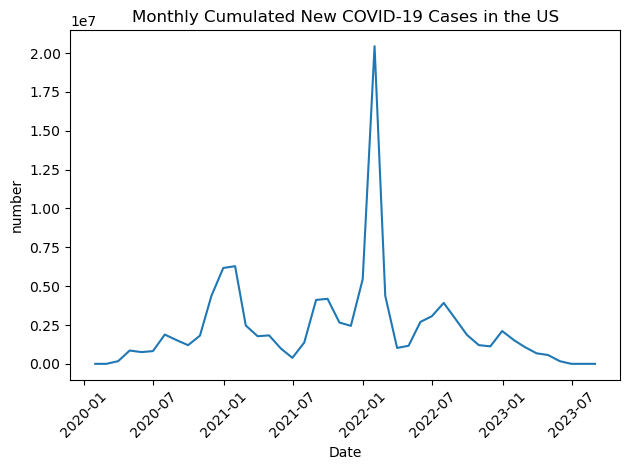

In [12]:
# Load the downloaded dataset (CSV file)
csv_file_path = 'Resources/owid-covid-data.csv'
covid_data = pd.read_csv(csv_file_path)
covid_data_US = covid_data[covid_data['location'] == 'United States']

# Save the filtered data to a new CSV file
covid_data_US.to_csv('Resources/us_covid_data.csv', index=False)

covid_data_US_new_cases = covid_data_US[["date", "new_cases"]]
covid_data_US_cleaned = covid_data_US_new_cases.dropna()

# Set 'Date' as the index
covid_data_US_cleaned['date'] = pd.to_datetime(covid_data_US_cleaned['date'])
covid_data_US_cleaned.set_index('date', inplace=True)

# cumulated monthly data
cumulated_data_m = covid_data_US_cleaned.resample('M').sum()

# Plotting
plt.plot(cumulated_data_m)
#covid_data_US_cleaned.plot()
plt.xlabel("Date")
plt.ylabel("number")
plt.title("Monthly Cumulated New COVID-19 Cases in the US")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Line regression between covid-19 new cases and oil company's stock price

In [13]:

# Define the date range based on COVID-19 data
start_date = cumulated_data_m.index.min()
end_date = cumulated_data_m.index.max()
#xom.history(period="max").tail()
ticker_string = " ".join(companyList)
stock_data = {}

for companyName in companyList:
    # Download data for each company
    companyDataFrame = yf.download(companyName, start_date, end_date)
    
    # Download data for specific tickers within a date range
    data_range = yf.download(ticker_string, start_date, end_date)
    
    # Store the closing prices for the company in the dictionary
    stock_data[companyName] = companyDataFrame['Close'].resample('M').last()

# Convert the dictionary to a DataFrame
stock_data_df  = pd.DataFrame(stock_data)

# delete last zero values of cumulated_data_m
cumulated_data_m = cumulated_data_m.iloc[:-3]
stock_data_df = stock_data_df.iloc[:-3]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  6 of 6 completed


In [14]:
saved_fig_path = "Results/line_regression_stock_covid.png"
# Define the columns you want to use from the data DataFrame and Gasoline_price_data
x_column = "COVID-19 new_cases"  
y_columns = companyList 

# Calculate the number of rows and columns for the subplot grid
num_rows = 3  
num_cols = 2  

# Create a subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing
plt.subplots_adjust(hspace=0.5)
# Create plots for each company's stock data
for i, y_column in enumerate(y_columns):
    # Extract x and y values
    x_values = cumulated_data_m["new_cases"]
    y_values = stock_data_df[y_column]
    
    # Perform linear regression
    slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
    line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    
    # Select the appropriate subplot for the current company
    ax = axes[i]
    
    # Create scatter plot
    ax.scatter(x_values, y_values, marker='o', label='Stock Price')
    
    # Plot the regression line
    regression_line = x_values * slope + intercept
    ax.plot(x_values, regression_line, color='red', label='Regression Line')
    
    # Annotate the equation on the plot
    ax.annotate(line_eq, (x_values.mean(), y_values.mean()), fontsize=10, color="red")
    
    # Add labels and title
    ax.set_xlabel("monthly cumulated new COVID-19 cases")
    ax.set_ylabel(y_column)
    ax.set_title(f'r-value: {round(rvalue, 2)}')
#Save the figure
plt.savefig(saved_fig_path)

# Close the figure
plt.close()
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

### COVID-19 and gasoline price

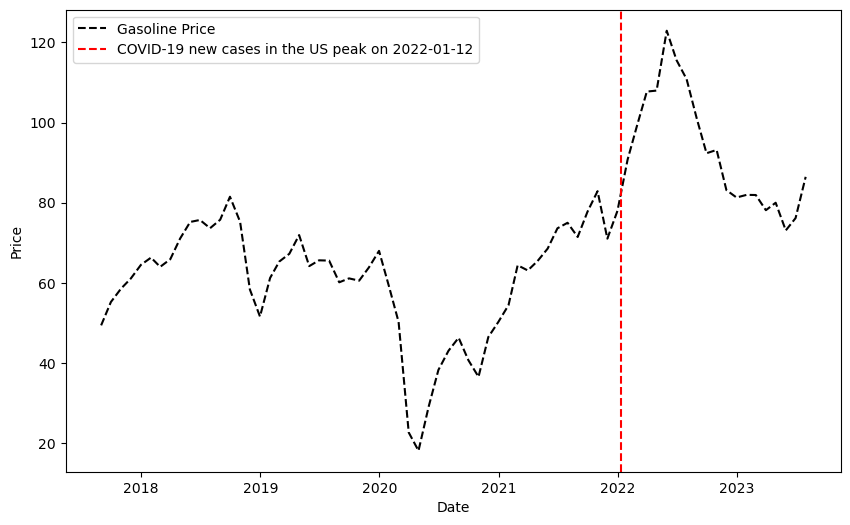

In [15]:
# maximum new cases in the US and date at the time
max_new_cases = covid_data_US_cleaned.max()
max_new_cases_date = covid_data_US_cleaned["new_cases"].idxmax()

plt.figure(figsize=(10, 6))
plt.plot(Gasoline_resampled_data.index, Gasoline_resampled_data['Value'], label="Gasoline Price", color='black', linestyle='dashed')
plt.axvline(x=max_new_cases_date, color='red', linestyle='--', label=f'COVID-19 new cases in the US peak on {max_new_cases_date.date()}')
# Add labels and title
plt.xlabel("Date")
plt.ylabel("Price")
#plt.title(" Gasoline Price Over Time")
plt.legend()
plt.show()